In [1]:
from optimpv import *
from optimpv.axBOtorch.axUtils import *
import pandas as pd
import numpy as np
from scipy import interpolate
import warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch, copy, os
from itertools import combinations
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import init_notebook_plotting, render
from botorch.models import SaasFullyBayesianSingleTaskGP, SingleTaskGP
# import logging

# from ray import train, tune
# from ray.tune.schedulers import AsyncHyperBandScheduler
# from ray.tune.search.ax import AxSearch


init_notebook_plotting()

# Suppress FutureWarning messages
# warnings.simplefilter(action='ignore', category=FutureWarning)
# ##part of the message is also okay
warnings.filterwarnings('ignore') 
params = []

mun = FitParam(name = 'l2.mu_n', value = 3e-5, bounds = [1e-5,1e-3], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$\mu_n$', unit='m$^2$ V$^{-1}$s$^{-1}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(mun)

mup = FitParam(name = 'l2.mu_p', value = 8e-4, bounds = [1e-5,1e-3], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$\mu_p$', unit=r'm$^2$ V$^{-1}$s$^{-1}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(mup)

bulk_tr = FitParam(name = 'l2.N_t_bulk', value = 1e20, bounds = [1e19,1e21], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$N_{T}$', unit=r'm$^{-3}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(bulk_tr)

int_trap = FitParam(name = 'l1.N_t_int', value = 4e12, bounds = [1e11,1e13], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$N_{T,int}^{ETL}$', unit='m$^{-2}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(int_trap)

Nions = FitParam(name = 'l2.N_ions', value = 1e22, bounds = [1e20,5e22], type='range', values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$C_{ions}$', unit='m$^{-3}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(Nions)

R_series = FitParam(name = 'R_series', value = 1e-4, bounds = [1e-5,1e-3], type='range', values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$R_{series}$', unit=r'$\Omega$ m$^2$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(R_series)

# original values
params_orig = copy.deepcopy(params)



[INFO 01-28 16:14:58] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 01-28 16:14:58] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


[{'par': 'l2.mu_n', 'val': '3e-05'}, {'par': 'l2.mu_p', 'val': '0.0008'}, {'par': 'l2.N_t_bulk', 'val': '1e+20'}, {'par': 'l1.N_t_int', 'val': '4000000000000.0'}, {'par': 'l2.N_cation', 'val': '1e+22'}, {'par': 'l2.N_anion', 'val': '1e+22'}, {'par': 'R_series', 'val': '0.0001'}]
(153, 2)
(153,)


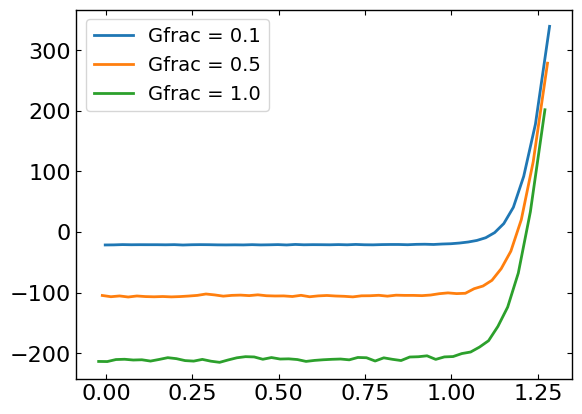

In [2]:
import pySIMsalabim as sim
from pySIMsalabim.experiments.JV_steady_state import *

session_path = os.path.join('/home/lecorre/Desktop/pySIMsalabim/', 'SIMsalabim','SimSS')
simss_device_parameters = os.path.join(session_path, 'simulation_setup.txt')

# Set the JV parameters
Gfracs = [0.1,0.5,1.0] # Fractions of the generation rate to simulate
# Gfracs = None
UUID = str(uuid.uuid4())

cmd_pars = []
for param in params:
    if param.name != 'l2.C_np_bulk' and param.name != 'offset_l2_l1.E_c' and param.name != 'offset_l2_l3.E_v' and param.name != 'Egap_l1.E_v' and param.name != 'offset_W_L.E_c' and param.name != 'l2.N_ions':
        cmd_pars.append({'par':param.name, 'val':str(param.value)})
    elif param.name == 'offset_l2_l1.E_c':
        cmd_pars.append({'par':'l1.E_c', 'val':str(3.9-param.value)})
        vv = 3.9-param.value
    elif param.name == 'l2.N_ions':
        cmd_pars.append({'par':'l2.N_cation', 'val':str(param.value)})
        cmd_pars.append({'par':'l2.N_anion', 'val':str(param.value)})
    elif param.name == 'l2.C_np_bulk':
        cmd_pars.append({'par':'l2.C_n_bulk', 'val':str(param.value)})
        cmd_pars.append({'par':'l2.C_p_bulk', 'val':str(param.value)})

    elif param.name == 'offset_l2_l3.E_v':
        cmd_pars.append({'par':'l3.E_v', 'val':str(5.53-param.value)})
    
    elif param.name == 'Egap_l1.E_v':
        cmd_pars.append({'par':'l1.E_v', 'val': str(vv+param.value)})
    
    elif param.name == 'offset_W_L.E_c':
        cmd_pars.append({'par':'W_L', 'val':str(vv-param.value)})


print(cmd_pars)

# Run the JV simulation
ret, mess = run_SS_JV(simss_device_parameters, session_path, JV_file_name = 'JV.dat', varFile= 'Var.dat',G_fracs = Gfracs, parallel = True, max_jobs = 3, UUID=UUID, cmd_pars=cmd_pars)

# import random noise
from numpy.random import default_rng
# save data for fitting
X,y = [],[]
if Gfracs is None:
    data = pd.read_csv(os.path.join(session_path, 'JV_'+UUID+'.dat'), sep=r'\s+') # Load the data
    Vext = np.asarray(data['Vext'].values)
    Jext = np.asarray(data['Jext'].values)
    G = np.ones_like(Vext)
    rng = default_rng()#
    noise = rng.standard_normal(Jext.shape) * 0.01 * Jext
    Jext = Jext + noise
    X= Vext
    y = Jext

    plt.figure()
    plt.plot(X,y)
    plt.show()
else:
    for Gfrac in Gfracs:
        data = pd.read_csv(os.path.join(session_path, 'JV_Gfrac_'+str(Gfrac)+'_'+UUID+'.dat'), sep=r'\s+') # Load the data
        Vext = np.asarray(data['Vext'].values)
        Jext = np.asarray(data['Jext'].values)
        G = np.ones_like(Vext)*Gfrac
        rng = default_rng()#
        noise = rng.standard_normal(Jext.shape) * 0.01 * Jext
        Jext = Jext + noise
        if len(X) == 0:
            X = np.vstack((Vext,G)).T
            y = Jext
        else:
            X = np.vstack((X,np.vstack((Vext,G)).T))
            y = np.hstack((y,Jext))

    print(X.shape)
    print(y.shape)


    plt.figure()
    for Gfrac in Gfracs:
        plt.plot(X[X[:,1]==Gfrac,0],y[X[:,1]==Gfrac],label='Gfrac = '+str(Gfrac))
    plt.legend()
    plt.show()




In [3]:
from optimpv.DDfits.JVAgent import JVAgent
metric = 'mse'
# metric = 'mse'
# loss = 'log10'
# loss = 'linear'
loss = 'soft_l1'

jv = JVAgent(params, X, y, session_path, simss_device_parameters,parallel = True, max_jobs = 3, metric = metric, loss = loss)

In [4]:
from optimpv.axBOtorch.axBOtorchOptimizer_runner import axBOtorchOptimizer_runner
from botorch.acquisition.logei import (
    qLogExpectedImprovement,
    qLogNoisyExpectedImprovement,
)
from  botorch.acquisition.monte_carlo import qUpperConfidenceBound
from ax.modelbridge.transforms.standardize_y import StandardizeY
from ax.modelbridge.transforms.unit_x import UnitX
from ax.modelbridge.transforms.remove_fixed import RemoveFixed
from ax.modelbridge.transforms.log import Log
from ax.models.torch.botorch_modular.surrogate import Surrogate
#import single task GP
from botorch.models.gp_regression import SingleTaskGP

# surr = Surrogate(SingleTaskGP)
# model_kwargs_list = [{}]
# for i in range(3):
#     model_kwargs_list.append({'torch_device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),'torch_dtype': torch.double,'botorch_acqf_class':qLogNoisyExpectedImprovement,'transforms':[RemoveFixed, Log,UnitX, StandardizeY],'acquisition_options':{'tau_relu':1e-7}})
# model_kwargs_list = [{},{'torch_device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),'torch_dtype': torch.double,'botorch_acqf_class':qLogNoisyExpectedImprovement,'transforms':[RemoveFixed, Log,UnitX, StandardizeY],},{'torch_device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),'torch_dtype': torch.double,'botorch_acqf_class':qUpperConfidenceBound,'transforms':[RemoveFixed, Log,UnitX, StandardizeY]},{'torch_device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),'torch_dtype': torch.double,'botorch_acqf_class':qLogNoisyExpectedImprovement,'transforms':[RemoveFixed, Log,UnitX, StandardizeY]}]
# model_gen_kwargs_list = [None,{'n':2,'joint_optimization':True},{'n':2,'joint_optimization':True},{'n':2,'joint_optimization':True}]
model_gen_kwargs_list = None
parameter_constraints = [f'l2.mu_p - l2.mu_n >= {0}']
# parameter_constraints = None
# print(len(model_kwargs_list))
# from gpytorch.kernels import MaternKernel
# from gpytorch.kernels import RBFKernel
# from gpytorch.constraints import Interval
#  acquisition_options
# prior = {'eta':100}
# acf_options
# optimizer = axBOtorchOptimizer(params = params, agents = jv, models = ['SOBOL','BOTORCH_MODULAR','BOTORCH_MODULAR','BOTORCH_MODULAR'],n_batches = [1,30,20,30], batch_size = [10,2,2,2], metrics = metric, minimize_list = True, thresholds = None, ax_client = None,  max_parallelism = 10,model_kwargs_list = model_kwargs_list, model_gen_kwargs_list = model_gen_kwargs_list, name = 'ax_opti',parameter_constraints = parameter_constraints)
# optimizer = axBOtorchOptimizer(params = params, agents = jv, models = ['SOBOL','BOTORCH_MODULAR','BOTORCH_MODULAR','BOTORCH_MODULAR'],n_batches = [1,30,20,30], batch_size = [100,2,2,2], metrics = metric, minimize_list = True, thresholds = None, ax_client = None,  max_parallelism = 10,model_kwargs_list = model_kwargs_list, model_gen_kwargs_list = model_gen_kwargs_list, name = 'ax_opti',parameter_constraints = parameter_constraints)
# from ax.models.torch.botorch_modular.utils import ModelConfig
# model_config = ModelConfig(covar_module_class='MaternKernel')
# from gpytorch.constraints import GreaterThan
# # (raw_lengthscale_constraint): Positive()
model_kwargs_list = [{},{'torch_device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),'torch_dtype': torch.double,'botorch_acqf_class':qLogNoisyExpectedImprovement,'transforms':[RemoveFixed, Log,UnitX, StandardizeY]}] #,'surrogate':Surrogate(SingleTaskGP,covar_module_class=RBFKernel,covar_module_options={'lengthscale_constraint':Interval(1e-6,100)})}]
                     
optimizer = axBOtorchOptimizer_runner(params = params, agents = jv, models = ['SOBOL','BOTORCH_MODULAR'],n_batches = [1,8], batch_size = [8,2], ax_client = None,  max_parallelism = 100,model_kwargs_list = model_kwargs_list, model_gen_kwargs_list = model_gen_kwargs_list, name = 'ax_opti',parameter_constraints = parameter_constraints)


In [5]:
optimizer._optimize()

[INFO 01-28 16:15:02] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


{}
{}
{'JV_JV_mse': ObjectiveProperties(minimize=True, threshold=100)}


[INFO 01-28 16:15:02] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='l2.mu_n', parameter_type=FLOAT, range=[1e-05, 0.001], log_scale=True), RangeParameter(name='l2.mu_p', parameter_type=FLOAT, range=[1e-05, 0.001], log_scale=True), RangeParameter(name='l2.N_t_bulk', parameter_type=FLOAT, range=[1e+19, 1e+21], log_scale=True), RangeParameter(name='l1.N_t_int', parameter_type=FLOAT, range=[100000000000.0, 10000000000000.0], log_scale=True), RangeParameter(name='l2.N_ions', parameter_type=FLOAT, range=[1e+20, 5e+22], log_scale=True), RangeParameter(name='R_series', parameter_type=FLOAT, range=[1e-05, 0.001], log_scale=True)], parameter_constraints=[ParameterConstraint(1.0*l2.mu_n + -1.0*l2.mu_p <= -0.0)]).
[INFO 01-28 16:15:02] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:02] Scheduler: Running trials [0]...



dekjhzdekj
8


[INFO 01-28 16:15:03] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:03] Scheduler: Waiting for completed trials (for 0.1 sec, currently running trials: 1).
[INFO 01-28 16:15:03] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:03] Scheduler: Waiting for completed trials (for 0.15000000000000002 sec, currently running trials: 1).
[INFO 01-28 16:15:03] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:03] Scheduler: Waiting for completed trials (for 0.22500000000000003 sec, currently running trials: 1).
[INFO 01-28 16:15:03] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:03] Scheduler: Waiting for completed trials (for 0.3375 sec, currently running trials: 1).
[INFO 01-28 16:15:04] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:04] Scheduler: Waiting for completed trials (for 0.5062500000000001 sec, currently running trials: 1).
[INFO 01-28 16:15:04] Sch

Batch: 8 / 24


[INFO 01-28 16:15:19] Scheduler: Running trials [1]...



dekjhzdekj
2


[INFO 01-28 16:15:20] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:20] Scheduler: Waiting for completed trials (for 0.1 sec, currently running trials: 1).
[INFO 01-28 16:15:20] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:20] Scheduler: Waiting for completed trials (for 0.15000000000000002 sec, currently running trials: 1).
[INFO 01-28 16:15:20] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:20] Scheduler: Waiting for completed trials (for 0.22500000000000003 sec, currently running trials: 1).
[INFO 01-28 16:15:20] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:20] Scheduler: Waiting for completed trials (for 0.3375 sec, currently running trials: 1).
[INFO 01-28 16:15:21] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:21] Scheduler: Waiting for completed trials (for 0.5062500000000001 sec, currently running trials: 1).
[INFO 01-28 16:15:21] Sch

Batch: 10 / 24


[INFO 01-28 16:15:32] Scheduler: Running trials [2]...



dekjhzdekj
2


[INFO 01-28 16:15:33] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:33] Scheduler: Waiting for completed trials (for 0.1 sec, currently running trials: 1).
[INFO 01-28 16:15:33] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:33] Scheduler: Waiting for completed trials (for 0.15000000000000002 sec, currently running trials: 1).
[INFO 01-28 16:15:34] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:34] Scheduler: Waiting for completed trials (for 0.22500000000000003 sec, currently running trials: 1).
[INFO 01-28 16:15:34] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:34] Scheduler: Waiting for completed trials (for 0.3375 sec, currently running trials: 1).
[INFO 01-28 16:15:34] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:34] Scheduler: Waiting for completed trials (for 0.5062500000000001 sec, currently running trials: 1).
[INFO 01-28 16:15:35] Sch

Batch: 12 / 24


[INFO 01-28 16:15:50] Scheduler: Running trials [3]...



dekjhzdekj
2


[INFO 01-28 16:15:51] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:51] Scheduler: Waiting for completed trials (for 0.1 sec, currently running trials: 1).
[INFO 01-28 16:15:51] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:51] Scheduler: Waiting for completed trials (for 0.15000000000000002 sec, currently running trials: 1).
[INFO 01-28 16:15:51] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:51] Scheduler: Waiting for completed trials (for 0.22500000000000003 sec, currently running trials: 1).
[INFO 01-28 16:15:51] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:51] Scheduler: Waiting for completed trials (for 0.3375 sec, currently running trials: 1).
[INFO 01-28 16:15:52] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:52] Scheduler: Waiting for completed trials (for 0.5062500000000001 sec, currently running trials: 1).
[INFO 01-28 16:15:52] Sch

Batch: 14 / 24


[INFO 01-28 16:15:57] Scheduler: Running trials [4]...



dekjhzdekj
2


[INFO 01-28 16:15:58] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:58] Scheduler: Waiting for completed trials (for 0.1 sec, currently running trials: 1).
[INFO 01-28 16:15:58] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:58] Scheduler: Waiting for completed trials (for 0.15000000000000002 sec, currently running trials: 1).
[INFO 01-28 16:15:58] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:58] Scheduler: Waiting for completed trials (for 0.22500000000000003 sec, currently running trials: 1).
[INFO 01-28 16:15:58] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:58] Scheduler: Waiting for completed trials (for 0.3375 sec, currently running trials: 1).
[INFO 01-28 16:15:59] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:15:59] Scheduler: Waiting for completed trials (for 0.5062500000000001 sec, currently running trials: 1).
[INFO 01-28 16:15:59] Sch

Batch: 16 / 24


[INFO 01-28 16:16:04] Scheduler: Running trials [5]...



dekjhzdekj
2


[INFO 01-28 16:16:05] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:05] Scheduler: Waiting for completed trials (for 0.1 sec, currently running trials: 1).
[INFO 01-28 16:16:05] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:05] Scheduler: Waiting for completed trials (for 0.15000000000000002 sec, currently running trials: 1).
[INFO 01-28 16:16:05] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:05] Scheduler: Waiting for completed trials (for 0.22500000000000003 sec, currently running trials: 1).
[INFO 01-28 16:16:05] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:05] Scheduler: Waiting for completed trials (for 0.3375 sec, currently running trials: 1).
[INFO 01-28 16:16:06] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:06] Scheduler: Waiting for completed trials (for 0.5062500000000001 sec, currently running trials: 1).
[INFO 01-28 16:16:06] Sch

Batch: 18 / 24


[INFO 01-28 16:16:11] Scheduler: Running trials [6]...



dekjhzdekj
2


[INFO 01-28 16:16:12] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:12] Scheduler: Waiting for completed trials (for 0.1 sec, currently running trials: 1).
[INFO 01-28 16:16:12] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:12] Scheduler: Waiting for completed trials (for 0.15000000000000002 sec, currently running trials: 1).
[INFO 01-28 16:16:12] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:12] Scheduler: Waiting for completed trials (for 0.22500000000000003 sec, currently running trials: 1).
[INFO 01-28 16:16:12] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:12] Scheduler: Waiting for completed trials (for 0.3375 sec, currently running trials: 1).
[INFO 01-28 16:16:13] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:13] Scheduler: Waiting for completed trials (for 0.5062500000000001 sec, currently running trials: 1).
[INFO 01-28 16:16:13] Sch

Batch: 20 / 24


[INFO 01-28 16:16:29] Scheduler: Running trials [7]...



dekjhzdekj
2


[INFO 01-28 16:16:30] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:30] Scheduler: Waiting for completed trials (for 0.1 sec, currently running trials: 1).
[INFO 01-28 16:16:30] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:30] Scheduler: Waiting for completed trials (for 0.15000000000000002 sec, currently running trials: 1).
[INFO 01-28 16:16:30] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:30] Scheduler: Waiting for completed trials (for 0.22500000000000003 sec, currently running trials: 1).
[INFO 01-28 16:16:30] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:30] Scheduler: Waiting for completed trials (for 0.3375 sec, currently running trials: 1).
[INFO 01-28 16:16:31] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:31] Scheduler: Waiting for completed trials (for 0.5062500000000001 sec, currently running trials: 1).
[INFO 01-28 16:16:31] Sch

Batch: 22 / 24


[INFO 01-28 16:16:38] Scheduler: Running trials [8]...



dekjhzdekj
2


[INFO 01-28 16:16:39] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:39] Scheduler: Waiting for completed trials (for 0.1 sec, currently running trials: 1).
[INFO 01-28 16:16:39] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:39] Scheduler: Waiting for completed trials (for 0.15000000000000002 sec, currently running trials: 1).
[INFO 01-28 16:16:39] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:39] Scheduler: Waiting for completed trials (for 0.22500000000000003 sec, currently running trials: 1).
[INFO 01-28 16:16:39] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:39] Scheduler: Waiting for completed trials (for 0.3375 sec, currently running trials: 1).
[INFO 01-28 16:16:40] Scheduler: Fetching data for newly completed trials: [].
[INFO 01-28 16:16:40] Scheduler: Waiting for completed trials (for 0.5062500000000001 sec, currently running trials: 1).
[INFO 01-28 16:16:40] Sch

Batch: 24 / 24


In [6]:
ax_client = optimizer.ax_client
best_parameters = ax_client.get_best_parameters()[0]
print(best_parameters)
jv.params_w(best_parameters,jv.params)
print(jv.get_SIMsalabim_clean_cmd(jv.params))
jv.package_SIMsalabim_files(jv.params,'simss')

[WARNING 01-28 16:16:51] ax.modelbridge.cross_validation: Metric JV_JV_mse was unable to be reliably fit.
[WARNING 01-28 16:16:51] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 01-28 16:16:51] ax.service.utils.best_point: Model fit is poor and data on objective metric JV_JV_mse is noisy; interpret best points results carefully.


{'l2.mu_n': 9.034411620804002e-05, 'l2.mu_p': 0.001, 'l2.N_t_bulk': 1.9546452544262704e+20, 'l1.N_t_int': 100000000000.0, 'l2.N_ions': 2.4581350986554136e+21, 'R_series': 1.622695639433415e-05}
./simss -l2.mu_n 9.034411620804002e-05 -l2.mu_p 0.001 -l2.N_t_bulk 1.9546452544262704e+20 -l1.N_t_int 100000000000.0 -l2.N_anion 2.4581350986554136e+21 -l2.N_cation 2.4581350986554136e+21 -R_series 1.622695639433415e-05


In [7]:
# plot the evolution of the optimization
render(ax_client.get_contour_plot(param_x="l2.mu_n", param_y="l2.mu_p", metric_name=optimizer.all_metrics[0]))
# render(ax_client.get_contour_plot(param_x="l2.N_t_bulk", param_y="l2.C_np_bulk", metric_name=metric))
from ax.plot.slice import plot_slice
model = ax_client.generation_strategy.model

# render(plot_slice(model=model, param_name="l2.mu_n", metric_name=optimizer.all_metrics[0]))
# render(plot_slice(model=model, param_name="l2.mu_p", metric_name=optimizer.all_metrics[0]))
render(plot_slice(model=model, param_name="l2.N_t_bulk", metric_name=optimizer.all_metrics[0]))
# render(plot_slice(model=model, param_name="l2.N_ions", metric_name=optimizer.all_metrics[0]))



[INFO 01-28 16:16:51] ax.service.ax_client: Retrieving contour plot with parameter 'l2.mu_n' on X-axis and 'l2.mu_p' on Y-axis, for metric 'JV_JV_mse'. Remaining parameters are affixed to the middle of their range.


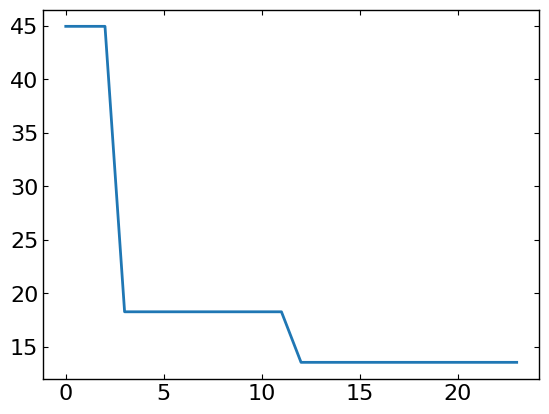

In [8]:
data = ax_client.experiment.fetch_data()

plt.plot(np.minimum.accumulate(data.df["mean"]), label="Best value seen so far")

# plt.yscale("log")


In [9]:
# # create dic with keys same as ax_client.experiment.trials[0].arm.parameters
# from ax.core.base_trial import TrialStatus as T
# dumdic = {}
# for key in ax_client.experiment.trials[0].arm.parameters.keys():
#     dumdic[key] = []

# # fill the dic with the values of the parameters
# for i in range(len(ax_client.experiment.trials)):
#     if ax_client.experiment.trials[i].status == T.COMPLETED:
#         for key in ax_client.experiment.trials[i].arm.parameters.keys():
#             dumdic[key].append(ax_client.experiment.trials[i].arm.parameters[key])


# data = ax_client.experiment.fetch_data().df

# target1 = data[data['metric_name'] == optimizer.all_metrics[0]]['mean']

# dumdic[optimizer.all_metrics[0]] = list(target1)


# dumdic['iteration'] = list(data[data['metric_name'] == optimizer.all_metrics[0]]['trial_index'])

# df = pd.DataFrame(dumdic)


# for par in params:
#     if par.name in df.columns:
#         if par.rescale:
#             if par.value_type == 'int':
#                 df[par.name] = df[par.name] * par.stepsize
#             else:
#                 df[par.name] = df[par.name] * par.fscale


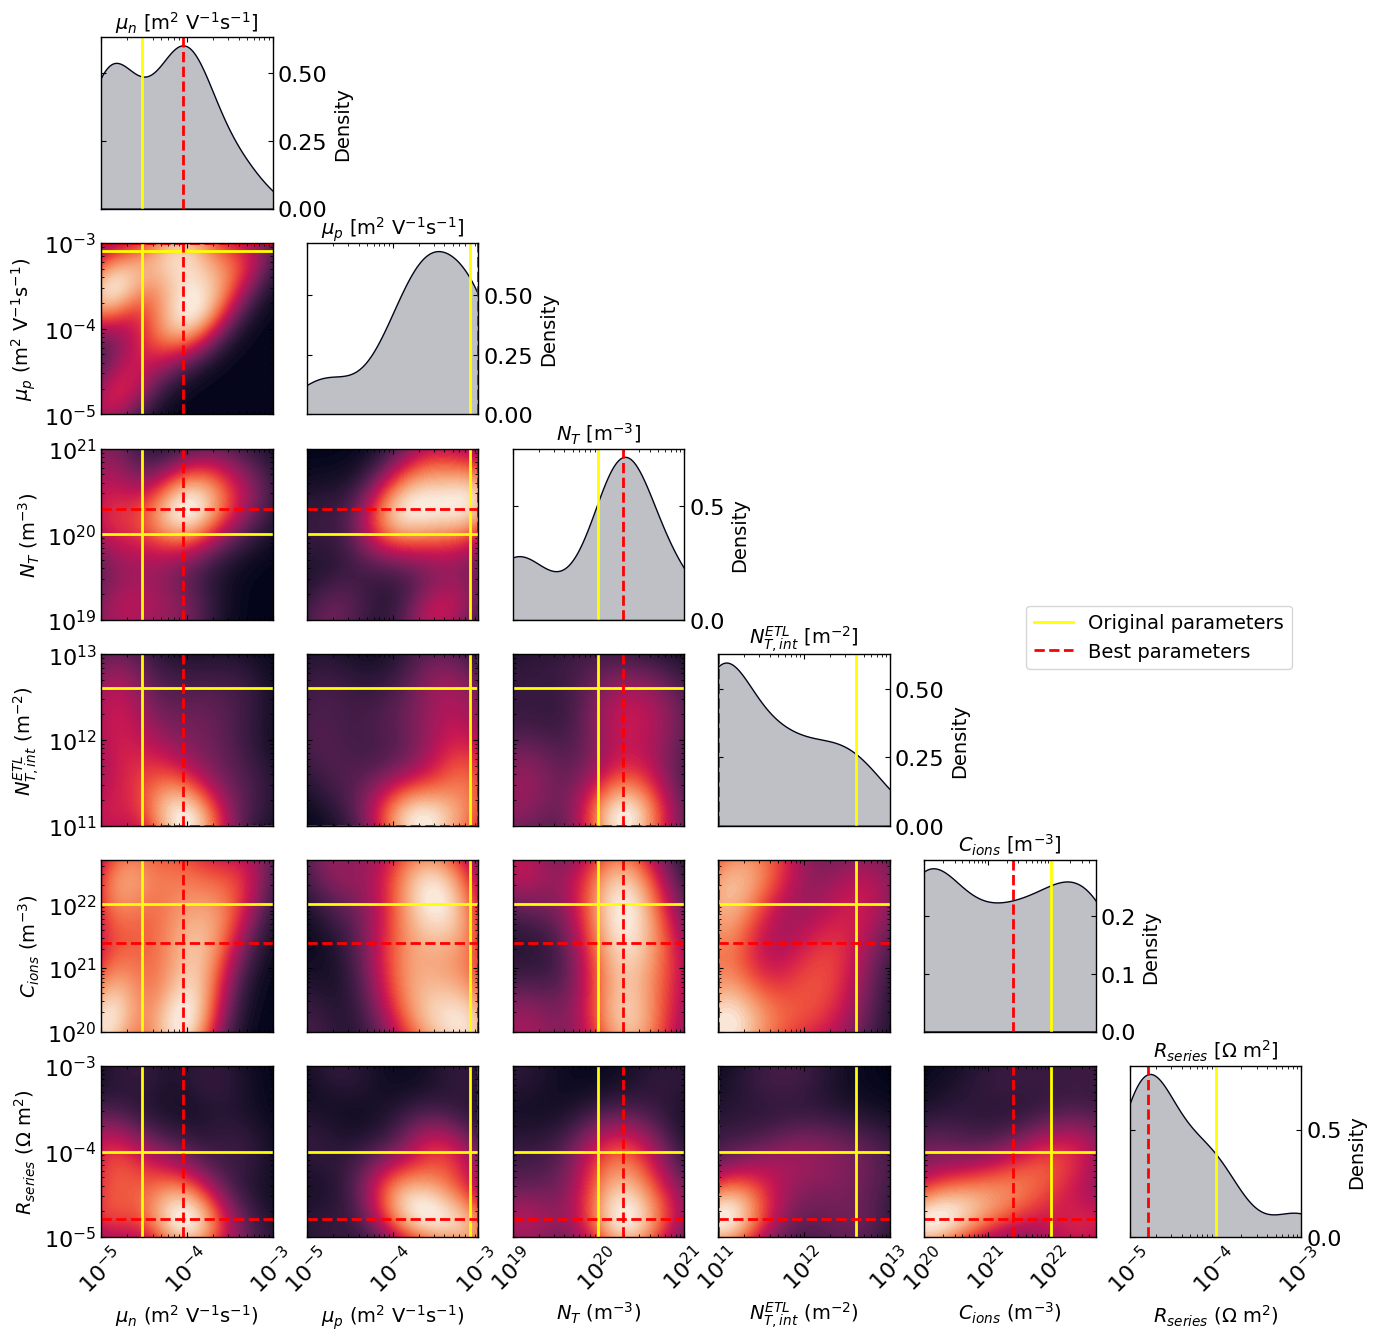

In [10]:
# get name of all parameters that are not 'fixed'
from optimpv.posterior.posterior import *
params_orig_dict = {}
for p in params_orig:
    params_orig_dict[p.name] = p.value
fig_dens, ax_dens = plot_density_exploration(params, optimizer.all_metrics[0], optimizer = optimizer, best_parameters = best_parameters, params_orig = params_orig_dict, optimizer_type = 'ax')


[WARNING 01-28 16:16:55] ax.modelbridge.cross_validation: Metric JV_JV_mse was unable to be reliably fit.
[WARNING 01-28 16:16:55] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 01-28 16:16:55] ax.service.utils.best_point: Model fit is poor and data on objective metric JV_JV_mse is noisy; interpret best points results carefully.


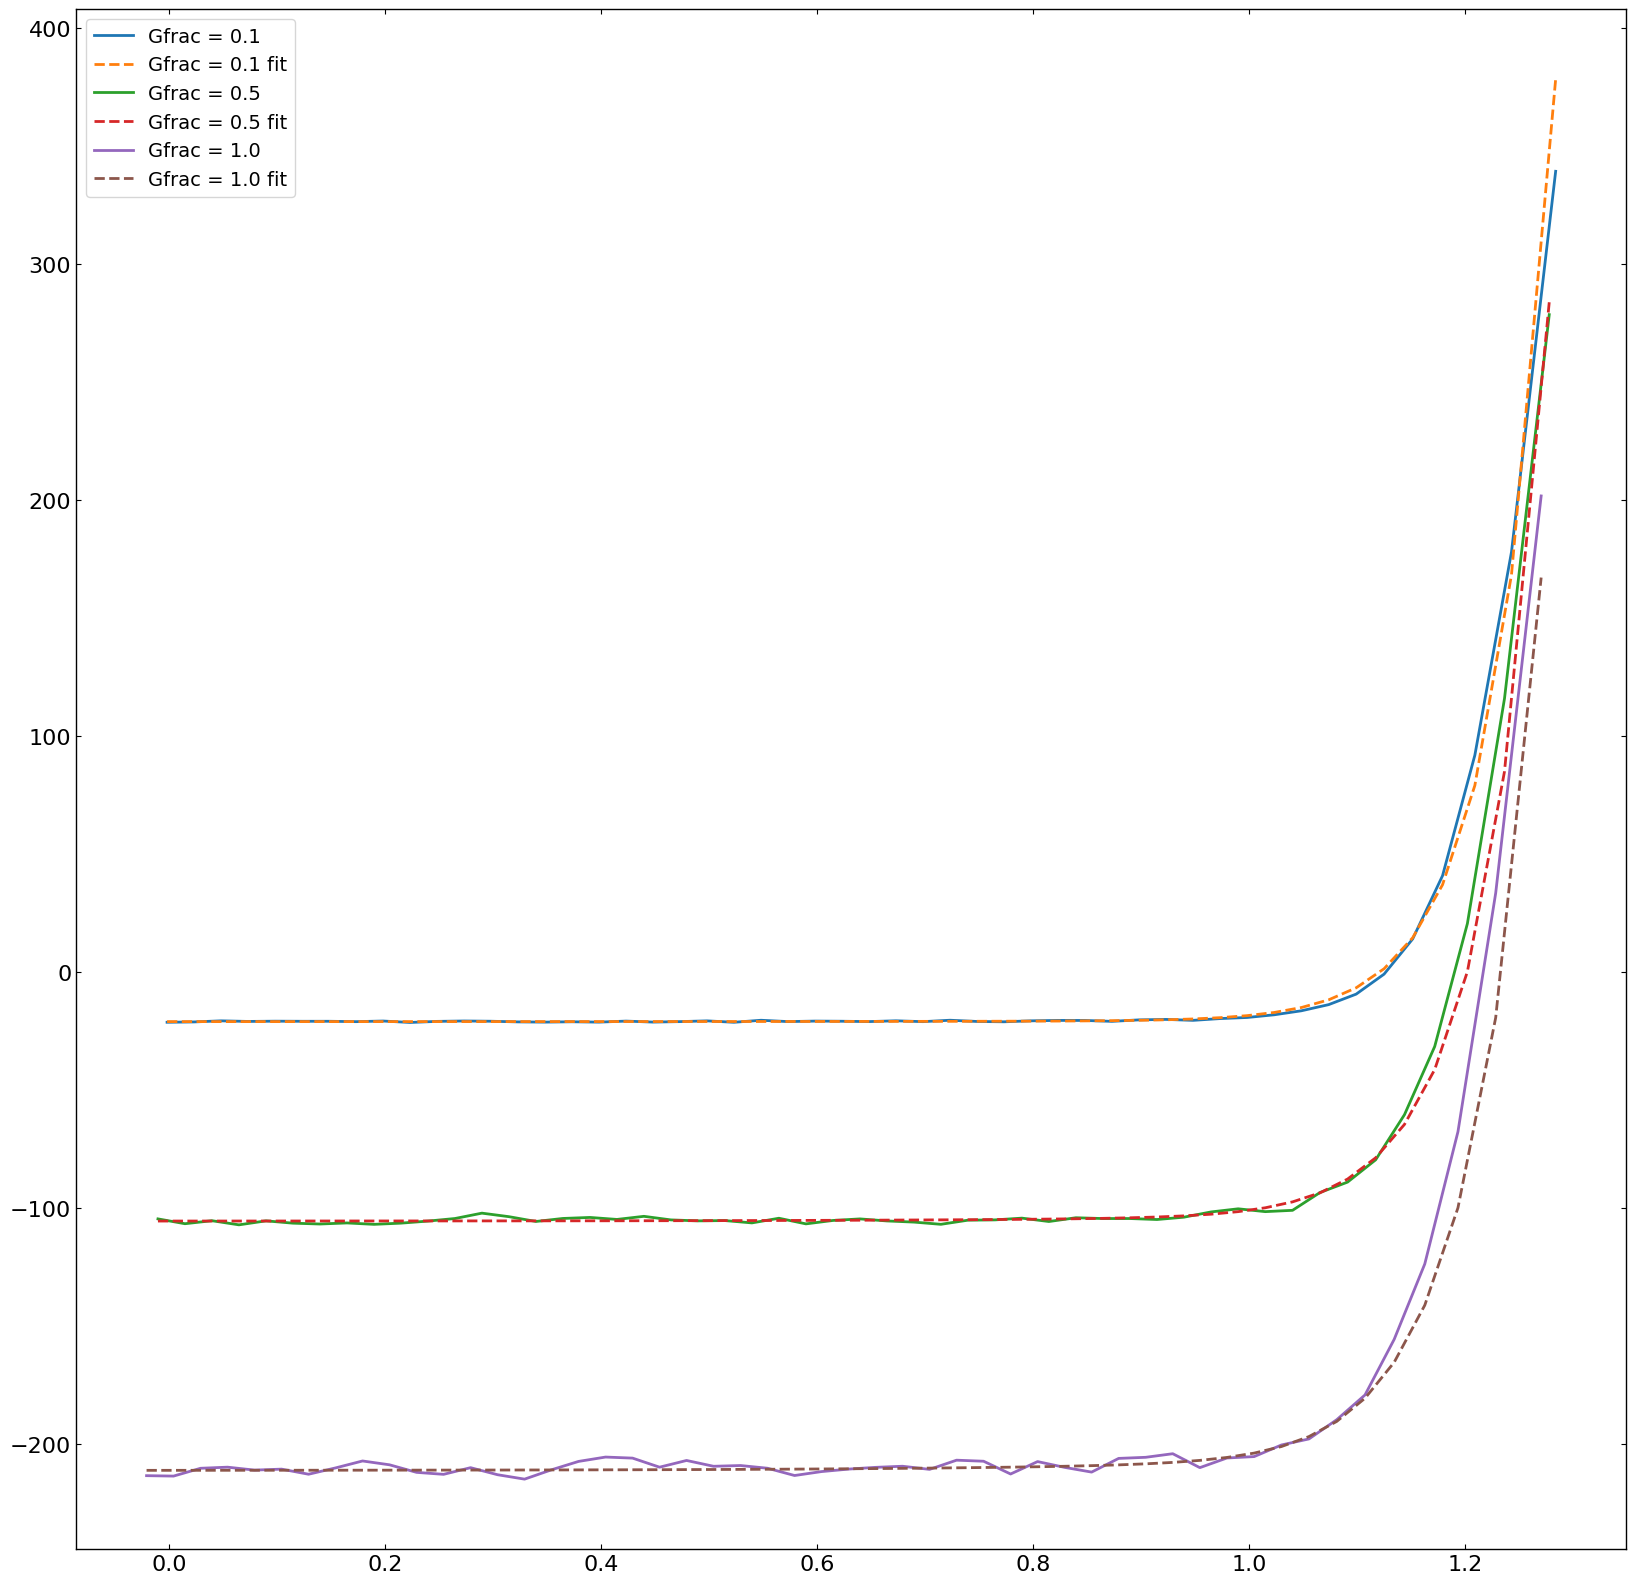

In [11]:
# rerun the simulation with the best parameters
yfit = jv.run(parameters=ax_client.get_best_parameters()[0])
# print(jv.run_Ax(parameters=results.get_best_result(metric=metric,mode='min',filter_nan_and_inf=True).config))
plt.figure(figsize=(20,20))
for Gfrac in Gfracs:
    plt.plot(X[X[:,1]==Gfrac,0],y[X[:,1]==Gfrac],label='Gfrac = '+str(Gfrac))
    plt.plot(X[X[:,1]==Gfrac,0],yfit[X[:,1]==Gfrac],label='Gfrac = '+str(Gfrac)+' fit',linestyle='--')
plt.legend()
plt.show()

In [12]:
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.contour import interact_contour
from ax.plot.diagnostic import interact_cross_validation
cv_results = cross_validate(model)
render(interact_cross_validation(cv_results))

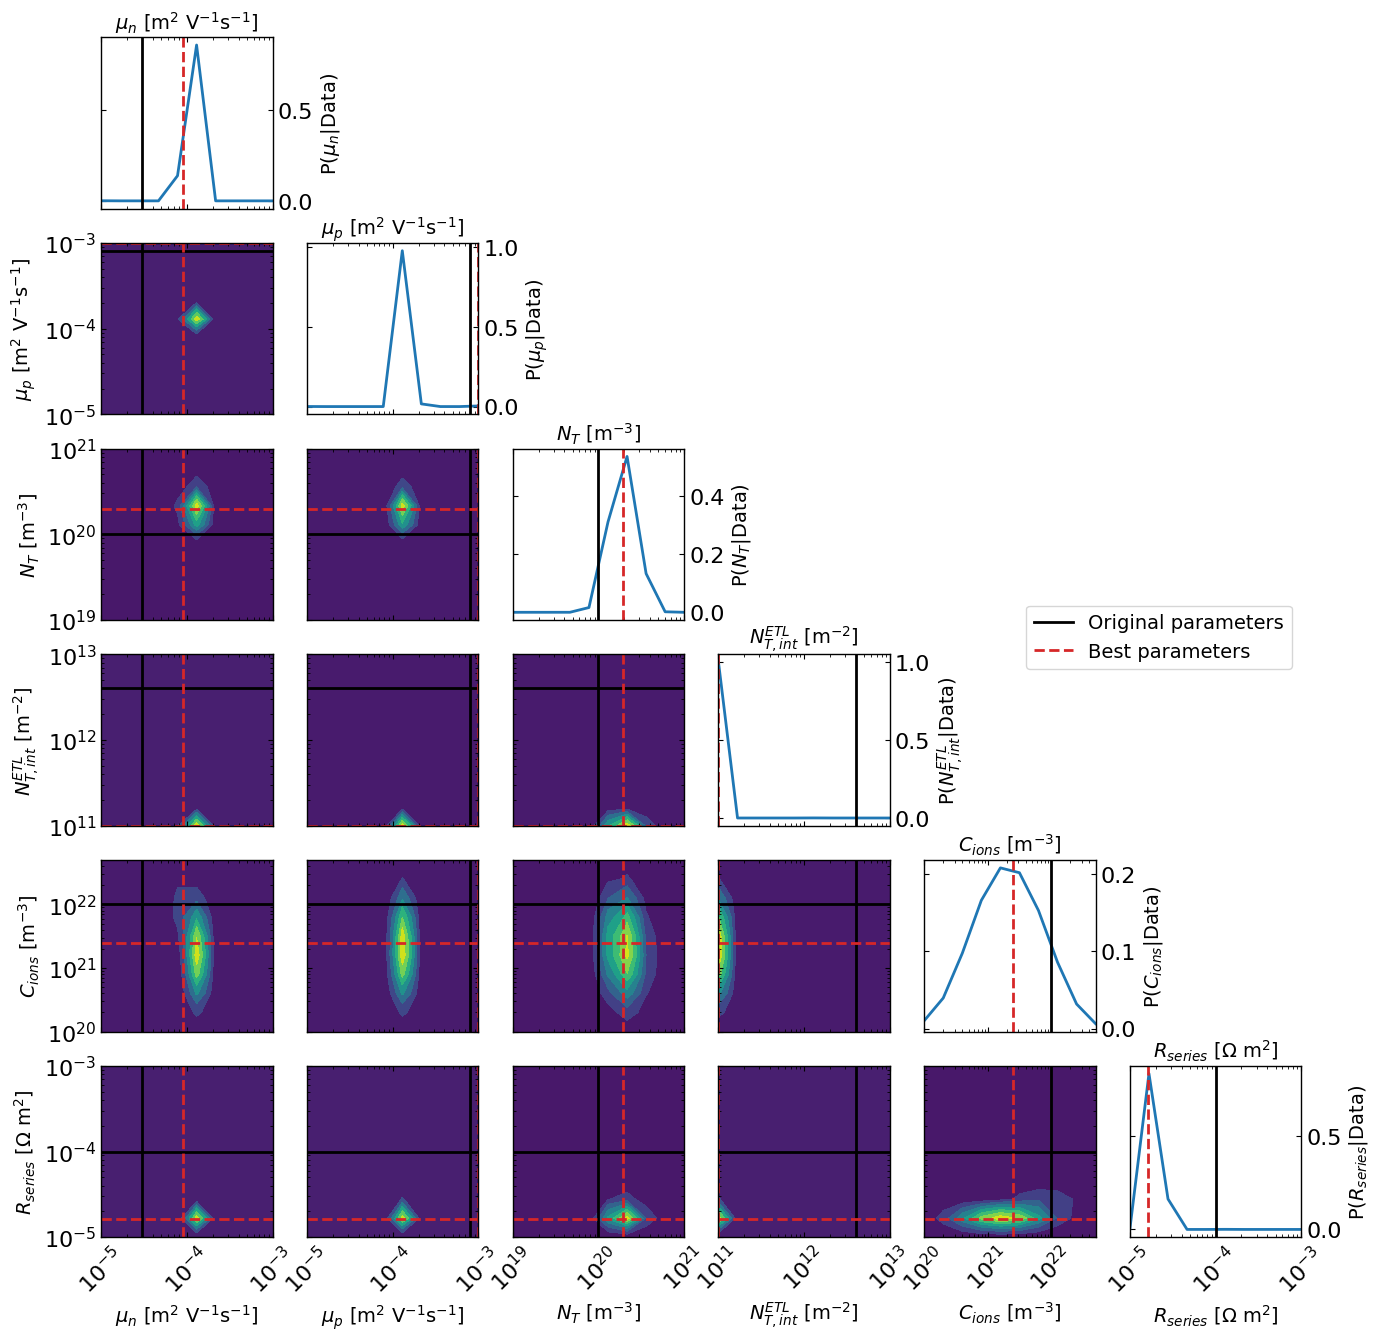

In [13]:

Nres = 10
objective_name = optimizer.all_metrics[0]
model = optimizer.ax_client.generation_strategy.model

    
fig, ax = devils_plot(params, Nres, objective_name, model, loss, best_parameters = best_parameters, params_orig = params_orig_dict, optimizer_type = 'ax')

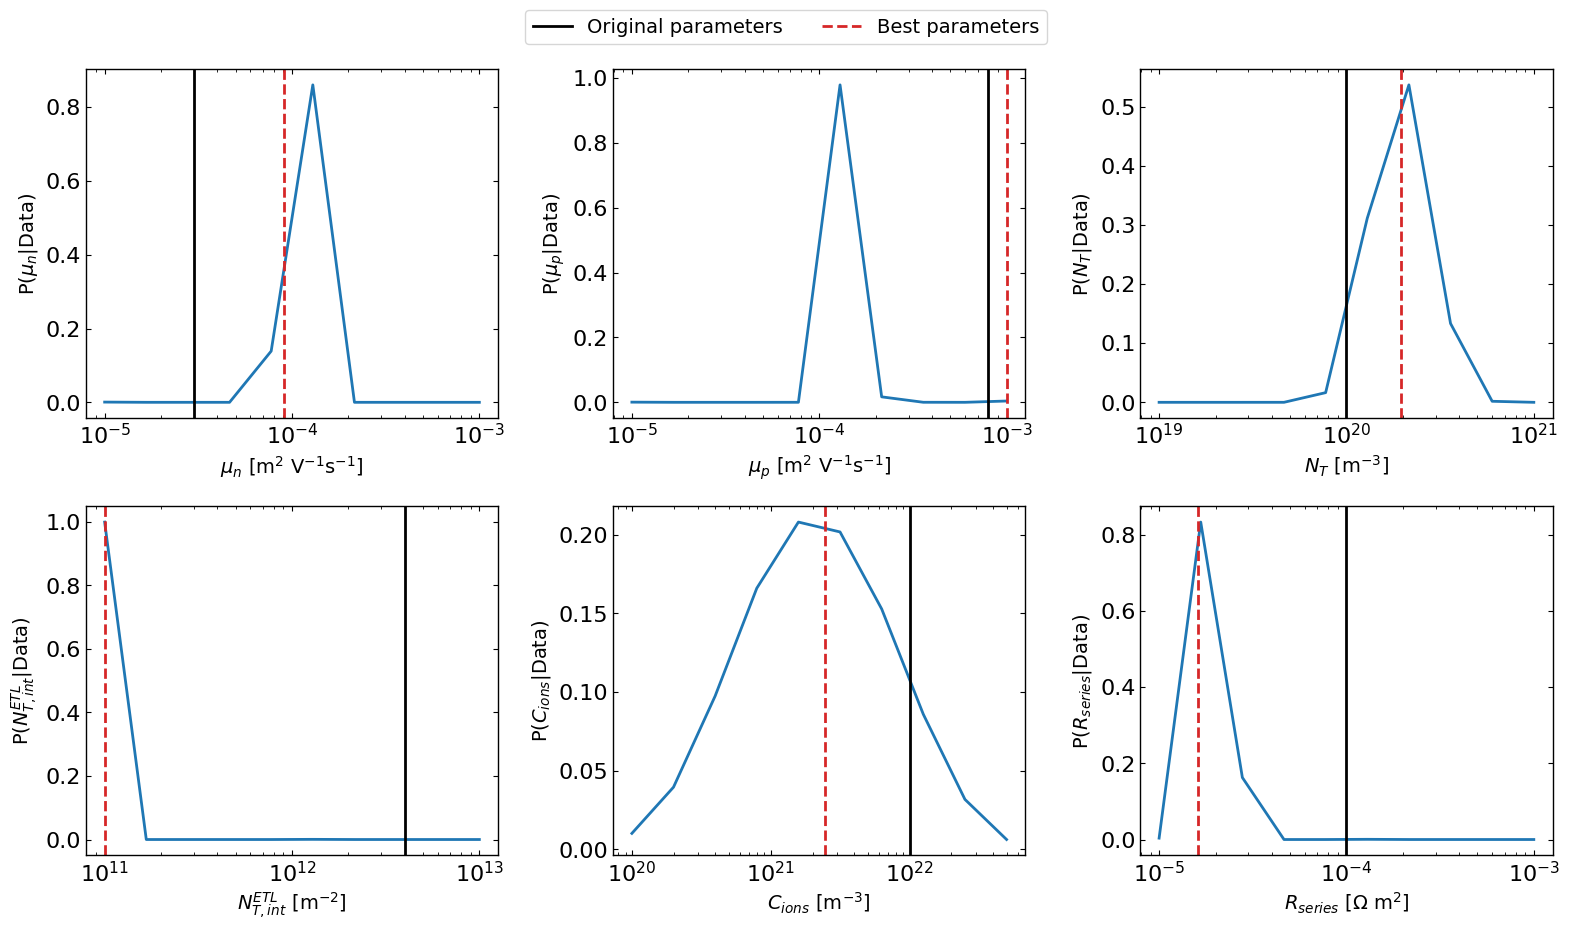

In [14]:
fig, ax = plot_1d_posteriors(params, Nres, objective_name, model, loss, best_parameters = best_parameters, params_orig = params_orig_dict, optimizer_type = 'ax')

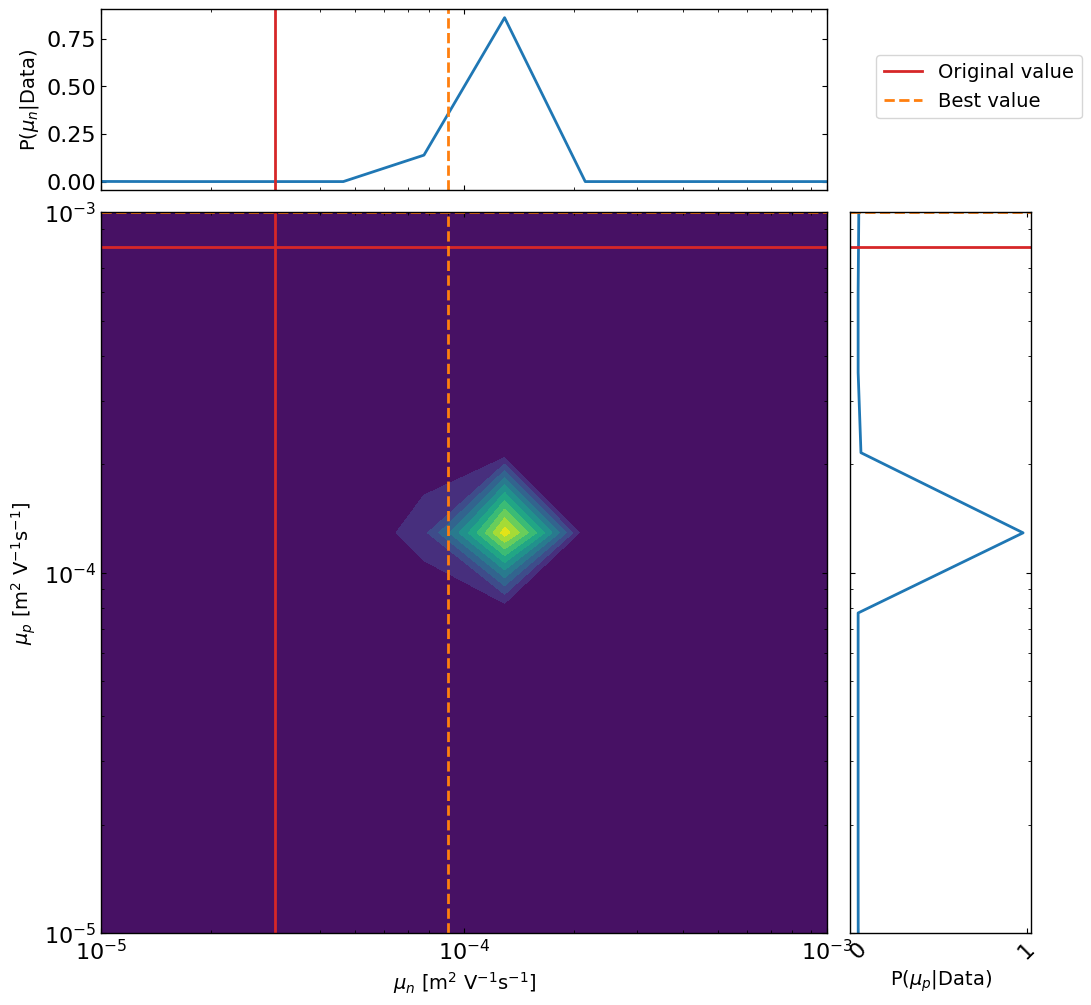

In [15]:
fig, ax = plot_1D_2D_posterior(params, 'l2.mu_n', 'l2.mu_p', 10, objective_name, model, loss, best_parameters = best_parameters, params_orig = params_orig_dict, optimizer_type = 'ax')

In [16]:
# Clean up the output files (comment out if you want to keep the output files)
sim.clean_all_output(session_path)
sim.delete_folders('tmp',session_path)